In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import math
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.neural_network import MLPClassifier

# lots of changes made here read carefully

In [2]:
#be careful about using 'find and replace' in this cell
#taking excel file data and putting into dataframe, and creating new variable for each cell line, some modifications from Caleb's HTML file in here
mm231=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MM231inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MM231inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)
#mm231[mm231<0]=0
mm231=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,mm231.shape[0])}),mm231.iloc[:,:4]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,mm231.shape[0])}),mm231.iloc[:,4:8]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(3,mm231.shape[0])}),mm231.iloc[:,8:]],axis=1)],axis=0)
mm231.insert(0,'cell_line',np.repeat('mm231',mm231.shape[0]))
mm231=mm231.reset_index(drop=True)
skbr3=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['SKBR3inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['SKBR3inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)

skbr3=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,skbr3.shape[0])}),skbr3.iloc[:,:4]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,skbr3.shape[0])}),skbr3.iloc[:,4:8]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(3,skbr3.shape[0])}),skbr3.iloc[:,8:]],axis=1)],axis=0)
skbr3.insert(0,'cell_line',np.repeat('skbr3',skbr3.shape[0]))
skbr3=skbr3.reset_index(drop=True)
mcf7=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MCF7inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MCF7inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)
#taking care of some NaN values in the mcf7 dataframe
mcf7=pd.concat([mcf7.iloc[:,:4].fillna(method='bfill'),mcf7.iloc[:,4:]],axis=1).dropna(axis=0,how='any').reset_index(drop=True).astype(object).copy()
#mcf7[mcf7<0]=0
mcf7=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,mcf7.shape[0])}),mcf7.iloc[:,:4]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,mcf7.shape[0])}),mcf7.iloc[:,4:8]],axis=1)],axis=0)
mcf7.insert(0,'cell_line',np.repeat('mcf7',mcf7.shape[0]))
mcf7=mcf7.reset_index(drop=True)


In [3]:
for trial in mm231.trial.unique():
    mm231.drop(mm231[mm231.trial==trial].index.max(),axis=0,inplace=True)
for trial in skbr3.trial.unique():
    skbr3.drop(skbr3[skbr3.trial==trial].index.max(),axis=0,inplace=True)
for trial in mcf7.trial.unique():
    mcf7.drop(mcf7[mcf7.trial==trial].index.max(),axis=0,inplace=True)

In [4]:
mm231=mm231.rename(columns={"Her2": "HER2"})
skbr3=skbr3.rename(columns={"Her2": "HER2"})
mcf7=mcf7.rename(columns={"Her2": "HER2"})

In [5]:
mm231

,cell_line,trial,EpCAM,HER2,CD44,IGF1R
0,mm231,1,-0.0881312,0.104973,0.989479,0.00185108
1,mm231,1,0.131166,-0.156575,1.8554,0.0785188
2,mm231,1,-0.059342,0.0667256,0.59461,0.0432075
3,mm231,1,-0.113893,0.053339,0.68377,0.0239837
4,mm231,1,-0.0187563,0.168379,0.888258,0.0023825
...,...,...,...,...,...,...
147,mm231,3,0.089582,0.257064,1.13875,0.0131244
148,mm231,3,0.19277,-0.00378351,1.15843,0.0477611
149,mm231,3,0.222644,-0.12995,1.96731,0.0890588
150,mm231,3,0.25218,0.00560481,1.38762,0.0593045


In [6]:
skbr3

,cell_line,trial,EpCAM,HER2,CD44,IGF1R
0,skbr3,1,-0.10999,0.652451,0.039156,0.067491
1,skbr3,1,-0.06618,0.230195,0.023738,-0.00276
2,skbr3,1,-0.07032,0.495735,0.033673,-0.01158
3,skbr3,1,0.283278,0.927984,0.119659,0.079347
4,skbr3,1,-0.00793,1.48431,0.194084,0.124917
...,...,...,...,...,...,...
147,skbr3,3,0.997588,1.40046,0.163618,0.0566113
148,skbr3,3,0.757674,0.962522,0.158397,-0.1049
149,skbr3,3,-0.0716846,0.925452,0.0734693,0.108263
150,skbr3,3,0.477565,1.31027,0.185903,0.124822


In [7]:
mcf7

,cell_line,trial,EpCAM,HER2,CD44,IGF1R
0,mcf7,1,0.505908,0.0992778,0.349198,0.185024
1,mcf7,1,1.21,0.22128,0.305781,0.00655982
2,mcf7,1,0.69633,0.0699004,0.156289,0.156549
3,mcf7,1,0.309665,0.0092093,0.0707674,0.0658008
4,mcf7,1,0.548672,0.116571,0.374886,0.199617
...,...,...,...,...,...,...
96,mcf7,2,0.685291,0.155486,1.28309,0.190166
97,mcf7,2,0.400844,0.0256968,0.056572,0.0122257
98,mcf7,2,0.460165,0.0017038,0.111792,-0.0158494
99,mcf7,2,0.551926,0.0454891,0.12484,0.124258


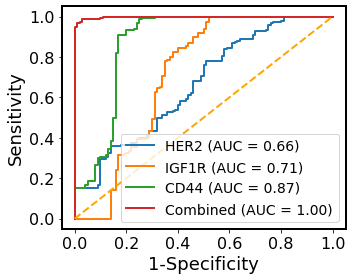

In [8]:
#careful about changing variables here, should try using find and replace 
rna_roc = ['HER2','IGF1R', 'CD44','all_three_combined']
cell_lines_considered=pd.concat([mm231,mcf7],axis=0)
fig,ax=plt.subplots(figsize=(5,4))
for marker in rna_roc:
    if marker=='all_three_combined':
        marker=['HER2','IGF1R', 'CD44']
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][marker]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        X_train=X_scaled
        y_train=y
        X_test=X_scaled
        y_test=y
        classifier = LogisticRegression(random_state=0,multi_class='multinomial',solver='newton-cg')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
        feature_importance = abs(classifier.coef_[0])
        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name='Combined',ax=ax,lw=2)
    else:
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][[marker]]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        X_train=X_scaled
        y_train=y
        X_test=X_scaled
        y_test=y
        classifier = LogisticRegression(random_state=0,multi_class='multinomial',solver='newton-cg')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
        feature_importance = abs(classifier.coef_[0])
        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name=marker,ax=ax,lw=2)
        
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
        
ax.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
ax.legend(fontsize=14)
#xlbl = ax.xaxis.get_label()
#ylbl = ax.yaxis.get_label()
#plt.setp(xlbl,fontsize=16)
#plt.setp(ylbl,fontsize=16)
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.setp(ax.get_xticklabels(),fontsize=16)
plt.setp(ax.get_yticklabels(),fontsize=16)
plt.tight_layout()   
#plt.savefig('Ray_roc_logistic_regression.jpg', dpi = 1000, bbox_inches='tight')


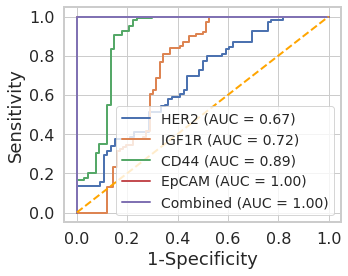

In [47]:
#careful about changing variables here, should try using find and replace 
rna_roc = ['HER2','IGF1R','CD44','EpCAM','all_combined']
cell_lines_considered=pd.concat([mm231,mcf7],axis=0)
fig,ax=plt.subplots(figsize=(5,4))
for marker in rna_roc:
    if marker=='all_combined':
        marker=['HER2','IGF1R','CD44','EpCAM']
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][marker]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        #X_train=X_scaled
        #y_train=y
        #X_test=X_scaled
        #y_test=y
        classifier = LogisticRegression(random_state=0,multi_class='multinomial',solver='newton-cg')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
        feature_importance = abs(classifier.coef_[0])
        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_train, y_train, alpha=1.0,name='Combined',ax=ax,lw=2)
    else:
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][[marker]]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        #X_train=X_scaled
        #y_train=y
        #X_test=X_scaled
        #y_test=y
        classifier = LogisticRegression(random_state=0,multi_class='multinomial',solver='newton-cg')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
        feature_importance = abs(classifier.coef_[0])
        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_train, y_train, alpha=1.0,name=marker,ax=ax,lw=2)
        
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
        
ax.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
ax.legend(fontsize=14)
#xlbl = ax.xaxis.get_label()
#ylbl = ax.yaxis.get_label()
#plt.setp(xlbl,fontsize=16)
#plt.setp(ylbl,fontsize=16)
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.setp(ax.get_xticklabels(),fontsize=16)
plt.setp(ax.get_yticklabels(),fontsize=16)
plt.tight_layout()   
#plt.savefig('Ray_roc_logistic_regression.jpg', dpi = 1000, bbox_inches='tight')


In [20]:
y.value_counts()

mm231    150
mcf7     100
Name: cell_line, dtype: int64

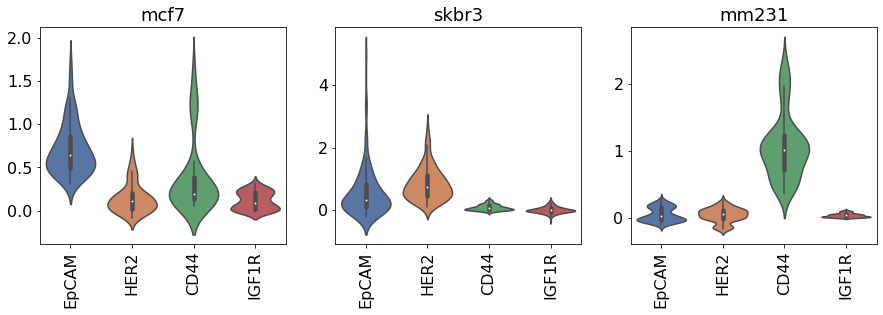

In [17]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
j=0
expression_data=['EpCAM']
for cell_line in expression_data:
    sns.set(style="whitegrid")
    ax=sns.violinplot(data=mcf7.iloc[:,2:],
                           scale='width',
                         ax=axs[0])
    axs[0].set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=16)
    axs[0].tick_params(axis='y', labelsize=16)
    axs[0].set_title(str(mcf7.cell_line.unique()[0]), fontsize=18)
    sns.set(style="whitegrid")
    ax=sns.violinplot(data=skbr3.iloc[:,2:],
                           scale='width',
                         ax=axs[1])
    axs[1].set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=16)
    axs[1].tick_params(axis='y', labelsize=16)
    axs[1].set_title(str(skbr3.cell_line.unique()[0]), fontsize=18)
    sns.set(style="whitegrid")
    ax=sns.violinplot(data=mm231.iloc[:,2:],
                           scale='width',
                         ax=axs[2])
    axs[2].set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=16)
    axs[2].tick_params(axis='y', labelsize=16)
    axs[2].set_title(str(mm231.cell_line.unique()[0]), fontsize=18)

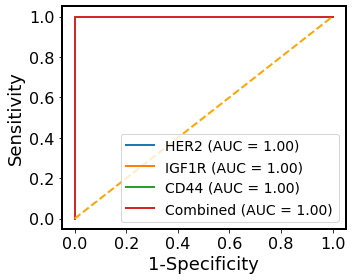

In [9]:
#careful about changing variables here, should try using find and replace 
rna_roc = ['HER2','IGF1R', 'CD44','all_three_combined']
cell_lines_considered=pd.concat([mm231,mcf7],axis=0)
fig,ax=plt.subplots(figsize=(5,4))
for marker in rna_roc:
    if marker=='all_three_combined':
        marker=['HER2','IGF1R', 'CD44']
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][marker]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        X_train=X_scaled
        y_train=y
        X_test=X_scaled
        y_test=y
        classifier = RandomForestClassifier(random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
#        feature_importance = abs(classifier.coef_[0])
#        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name='Combined',ax=ax,lw=2)
    else:
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][[marker]]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        X_train=X_scaled
        y_train=y
        X_test=X_scaled
        y_test=y
        classifier = RandomForestClassifier(random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
#        feature_importance = abs(classifier.coef_[0])
#        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name=marker,ax=ax,lw=2)
        
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
        
ax.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
ax.legend(fontsize=14)
#xlbl = ax.xaxis.get_label()
#ylbl = ax.yaxis.get_label()
#plt.setp(xlbl,fontsize=16)
#plt.setp(ylbl,fontsize=16)
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.setp(ax.get_xticklabels(),fontsize=16)
plt.setp(ax.get_yticklabels(),fontsize=16)
plt.tight_layout()   
#plt.savefig('Ray_roc_logistic_regression.jpg', dpi = 1000, bbox_inches='tight')


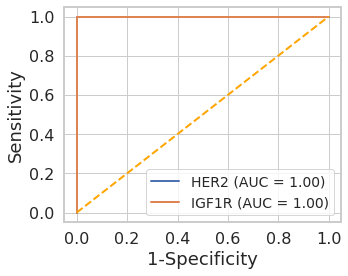

In [24]:
#careful about changing variables here, should try using find and replace 
rna_roc = ['HER2','IGF1R']
cell_lines_considered=pd.concat([mm231,mcf7],axis=0)
fig,ax=plt.subplots(figsize=(5,4))
for marker in rna_roc:
    if marker=='all_three_combined':
        marker=['HER2','IGF1R', 'CD44']
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][marker]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        X_train=X_scaled
        y_train=y
        X_test=X_scaled
        y_test=y
        classifier = RandomForestClassifier(random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
#        feature_importance = abs(classifier.coef_[0])
#        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name='Combined',ax=ax,lw=2)
    else:
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][[marker]]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        X_train=X_scaled
        y_train=y
        X_test=X_scaled
        y_test=y
        classifier = RandomForestClassifier(random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
#        feature_importance = abs(classifier.coef_[0])
#        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name=marker,ax=ax,lw=2)
        
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
        
ax.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
ax.legend(fontsize=14)
#xlbl = ax.xaxis.get_label()
#ylbl = ax.yaxis.get_label()
#plt.setp(xlbl,fontsize=16)
#plt.setp(ylbl,fontsize=16)
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.setp(ax.get_xticklabels(),fontsize=16)
plt.setp(ax.get_yticklabels(),fontsize=16)
plt.tight_layout()   
#plt.savefig('Ray_roc_logistic_regression.jpg', dpi = 1000, bbox_inches='tight')


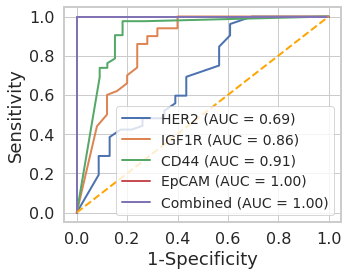

In [36]:
#careful about changing variables here, should try using find and replace 
rna_roc = ['HER2','IGF1R','CD44','EpCAM','all_four_combined']
cell_lines_considered=pd.concat([mm231,mcf7],axis=0)
fig,ax=plt.subplots(figsize=(5,4))
for marker in rna_roc:
    if marker=='all_four_combined':
        marker=['HER2','IGF1R', 'CD44','EpCAM']
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][marker]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        #X_train=X_scaled
        #y_train=y
        #X_test=X_scaled
        #y_test=y
        classifier = RandomForestClassifier(random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
#        feature_importance = abs(classifier.coef_[0])
#        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name='Combined',ax=ax,lw=2)
    else:
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][[marker]]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        #X_train=X_scaled
        #y_train=y
        #X_test=X_scaled
        #y_test=y
        classifier = RandomForestClassifier(random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
#        feature_importance = abs(classifier.coef_[0])
#        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name=marker,ax=ax,lw=2)
        
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
        
ax.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
ax.legend(fontsize=14)
#xlbl = ax.xaxis.get_label()
#ylbl = ax.yaxis.get_label()
#plt.setp(xlbl,fontsize=16)
#plt.setp(ylbl,fontsize=16)
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.setp(ax.get_xticklabels(),fontsize=16)
plt.setp(ax.get_yticklabels(),fontsize=16)
plt.tight_layout()   
#plt.savefig('Ray_roc_logistic_regression.jpg', dpi = 1000, bbox_inches='tight')


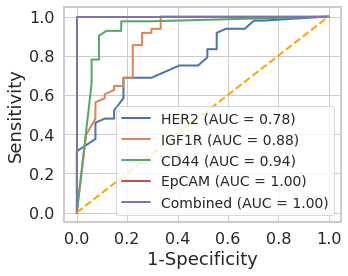

In [37]:
#careful about changing variables here, should try using find and replace 
rna_roc = ['HER2','IGF1R','CD44','EpCAM','all_four_combined']
cell_lines_considered=pd.concat([mm231,mcf7],axis=0)
fig,ax=plt.subplots(figsize=(5,4))
for marker in rna_roc:
    if marker=='all_four_combined':
        marker=['HER2','IGF1R', 'CD44','EpCAM']
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][marker]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        #X_train=X_scaled
        #y_train=y
        #X_test=X_scaled
        #y_test=y
        classifier = RandomForestClassifier(random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
#        feature_importance = abs(classifier.coef_[0])
#        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name='Combined',ax=ax,lw=2)
    else:
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][[marker]]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
        #X_train=X_scaled
        #y_train=y
        #X_test=X_scaled
        #y_test=y
        classifier = RandomForestClassifier(random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
#        feature_importance = abs(classifier.coef_[0])
#        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name=marker,ax=ax,lw=2)
        
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
        
ax.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
ax.legend(fontsize=14)
#xlbl = ax.xaxis.get_label()
#ylbl = ax.yaxis.get_label()
#plt.setp(xlbl,fontsize=16)
#plt.setp(ylbl,fontsize=16)
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.setp(ax.get_xticklabels(),fontsize=16)
plt.setp(ax.get_yticklabels(),fontsize=16)
plt.tight_layout()   
#plt.savefig('Ray_roc_logistic_regression.jpg', dpi = 1000, bbox_inches='tight')


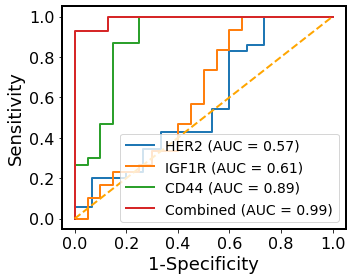

In [33]:
#careful about changing variables here, should try using find and replace 
rna_roc = ['HER2','IGF1R', 'CD44','all_three_combined']
cell_lines_considered=pd.concat([mm231,mcf7],axis=0)
fig,ax=plt.subplots(figsize=(5,4))
for marker in rna_roc:
    if marker=='all_three_combined':
        marker=['HER2','IGF1R', 'CD44']
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][marker]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
        #X_train=X_scaled
        #y_train=y
        #X_test=X_scaled
        #y_test=y
        classifier = LogisticRegression(random_state=0,multi_class='multinomial',solver='newton-cg')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
        feature_importance = abs(classifier.coef_[0])
        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name='Combined',ax=ax,lw=2)
    else:
        accuracy=[]
        X=cell_lines_considered.iloc[:,2:][[marker]]
        y=cell_lines_considered['cell_line']
        #Scale data
        scaler = StandardScaler()
        scaler.fit(X) 
        X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
        #X_train=X_scaled
        #y_train=y
        #X_test=X_scaled
        #y_test=y
        classifier = LogisticRegression(random_state=0,multi_class='multinomial',solver='newton-cg')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
        accuracy.append(accuracy_score(y_test,y_pred))
        feature_importance = abs(classifier.coef_[0])
        feature_importance =feature_importance / feature_importance.max()
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        #featfig = plt.figure(figsize=(10,8))
        #featax = featfig.add_subplot(1, 1, 1)
        #featax.barh(pos, feature_importance[sorted_idx], align='center')
        #print(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx])
        #featax.set_yticks(pos)
        #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
        #featax.set_xlabel('Relative Feature Importance')
        RocCurveDisplay.from_estimator(classifier, X_test, y_test, alpha=1.0,name=marker,ax=ax,lw=2)
        
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
        
ax.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
ax.legend(fontsize=14)
#xlbl = ax.xaxis.get_label()
#ylbl = ax.yaxis.get_label()
#plt.setp(xlbl,fontsize=16)
#plt.setp(ylbl,fontsize=16)
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.setp(ax.get_xticklabels(),fontsize=16)
plt.setp(ax.get_yticklabels(),fontsize=16)
plt.tight_layout()   
#plt.savefig('Ray_roc_logistic_regression.jpg', dpi = 1000, bbox_inches='tight')
